# Deep Convolutional Generative Adversarial Network

## Step 0: Setup

### Import Packages 

In [1]:
import os
import glob
import datetime

import imageio
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print("%d GPUs are available for tensorflow %s in current environment." % 
      (len(tf.config.experimental.list_physical_devices('GPU')), tf.__version__))
%load_ext tensorboard

0 GPUs are available for tensorflow 2.0.0 in current environment.


### Set the Paths of the Outputs

In [2]:
# get the dictionary for the project
pwd = os.path.dirname(os.getcwd())
# set and create the path for log file for tesnorboard
log_dir = os.path.join(pwd, 'outputs', 'logs')
os.makedirs(log_dir, exist_ok = True)
# set and create the path for saving the images
image_dir = os.path.join(pwd, 'outputs', 'images')
os.makedirs(image_dir, exist_ok = True)
# set and create the path for saving the weights of the model
checkpoint_dir = os.path.join(pwd, 'outputs', 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok = True)

### Load and Prepare the Dataset

In [3]:
# Batch size
BATCH = 32
# Buffer size
BUFFER = 60000 

In [4]:
(mnist_train, _), (mnist_test, _) = tf.keras.datasets.mnist.load_data()
print("shape of MNIST images is: " + str(mnist_train.shape))

shape of MNIST images is: (60000, 28, 28)


In [5]:
def preprocess(x):
    x = 2*tf.cast(x, dtype=tf.float32)/255 - 1
    # expand the 3d tensor to 4d
    x = tf.expand_dims(x, axis=-1)
    return x

In [6]:
mnist_train_db = tf.data.Dataset.from_tensor_slices(mnist_train)
mnist_train_db = mnist_train_db.map(preprocess).shuffle(BUFFER).batch(BATCH, drop_remainder=True)

mnist_val_db = tf.data.Dataset.from_tensor_slices(mnist_test)
mnist_val_db = mnist_val_db.map(preprocess).shuffle(BUFFER).batch(BATCH, drop_remainder=True)

In [7]:
# get one batch and check the dimension of this batch
samples = next(iter(mnist_val_db))
print("shape of one batch for MNIST images is: " + str(samples.shape))

shape of one batch for MNIST images is: (32, 28, 28, 1)


## Step 2: Define the Generator and Discriminator

### The Generator

In [8]:
class Generator(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.fc0 = layers.Dense(7*7*256, use_bias=False)
        self.bn0 = layers.BatchNormalization()
        
        self.conv1 = layers.Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        
        self.conv2 = layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        
        self.conv3 = layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', use_bias=False)
         
    def call(self, inputs, training=None):
        x = self.fc0(inputs)   
        assert x.shape == (BATCH, 7*7*256)
        x = tf.reshape(x, [-1, 7, 7, 256]) 
        x = tf.nn.leaky_relu(x)
        
        x = tf.nn.leaky_relu(self.bn1(self.conv1(x), training=training))
        assert x.shape == (BATCH, 7, 7, 128)
        
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        assert x.shape == (BATCH, 14, 14, 64)
        
        image = tf.math.tanh(self.conv3(x))
        assert image.shape == (BATCH, 28, 28, 1)
        
        return image

In [9]:
generator = Generator()
seed = tf.random.normal([BATCH, 100])
image_fake = generator(seed, training=False)
print("The shape of the output of the generator is: " + str(image_fake.shape))

The shape of the output of the generator is: (32, 28, 28, 1)


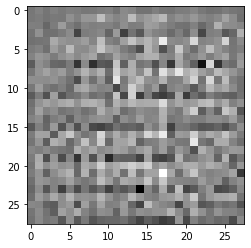

In [10]:
plt.imshow(image_fake[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

In [11]:
class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same')
        self.dropout1 = layers.Dropout(0.3)
        
        self.conv2 = layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.3)
        
        self.conv3 = layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.3)
        
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(1)
        
    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self.dropout1(self.conv1(inputs)))
        x = self.dropout2(tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training)))
        x = self.dropout3(tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training)))
        
        x = self.flatten(x)
        logits = self.fc(x)
        
        return logits

In [12]:
discriminator = Discriminator()
logits = discriminator(image_fake, training=False)
print("The shape of logits given by discriminator is: " + str(logits.shape))

The shape of logits given by discriminator is: (32, 1)


## Step 3: Define some Helper Functions

In [13]:
loss_cal = tf.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss Calculator

In [14]:
def discriminator_loss_cal(generator, discriminator, seed, image_true, training):
    
    image_fake = generator(seed, training)
    
    # treat real image as real
    logits_real = discriminator(image_true, training)
    loss_real = tf.reduce_mean(loss_cal(tf.ones_like(logits_real), logits_real))
    # treat fake image as fake
    logits_fake = discriminator(image_fake, training)
    loss_fake = tf.reduce_mean(loss_cal(tf.zeros_like(logits_fake), logits_fake))  
    loss = loss_fake + loss_real
    
    return loss

### Generator Loss Calculator

In [15]:
def generator_loss_cal(generator, discriminator, seed, training):
    
    image_fake = generator(seed, training)
    logits_fake = discriminator(image_fake, training)
    
    loss = tf.reduce_mean(loss_cal(tf.ones_like(logits_fake), logits_fake))     
    return loss

### Image Saver

In [16]:
def save_image(images, height, width, image_path, index):

    images = ((images + 1.0) * 127.5).astype(np.uint8)
    # final picture which save as PNG
    picture = np.array([])
    
    row = np.array([])
    for i in range(height*width):
        # concat image into a row
        if row.size == 0:
            row = images[i]
        else:
            row = np.concatenate((row, images[i]), axis=1)

        # concat image row to picture
        if (i+1) % width == 0:
            if picture.size == 0:
                picture = row
            else:
                picture = np.concatenate((picture, row), axis=0)
            # reset single row
            row = np.array([])
    
    picture_board = tf.expand_dims(tf.cast(picture, dtype=tf.uint8), 0)
    with summary_writer.as_default(): 
        tf.summary.image('train-fake-images:', picture_board, step=index)
    
    picture = np.squeeze(picture, axis=2)
    Image.fromarray(picture, 'P').save(image_path)

### Step 4: Define the Training Loop

In [17]:
# number of epochs
EPOCH = 10
# step size, i.e. number of batches per validation
STEP = 100
SEED = 100
LEARNING_RATE = 1e-3

In [18]:
generator_optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [19]:
# the time stamp
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
structure = 'GAN'
dataset = 'MNIST'
config = "%s-%s-%s" % (structure, dataset, stamp)

# save the training process
checkpoint_prefix = os.path.join(checkpoint_dir, config, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# the log file created for tensorborad for this time of training
cur_log_dir = os.path.join(log_dir, stamp)
summary_writer = tf.summary.create_file_writer(cur_log_dir) 
# the file for saving images for this time of training
cur_image_dir = os.path.join(image_dir, stamp)
os.makedirs(cur_image_dir, exist_ok = True)
# if you want to see the visualization during the traing, run this line
# %tensorboard --logdir=log_dir

In [21]:
# number of batches have trained
index = -1
for epoch in range(EPOCH):
    
    for step, image_true in enumerate(mnist_val_db):
        
        seed = tf.random.uniform([BATCH, SEED], minval=-1, maxval=1)
        # train Discriminator
        with tf.GradientTape() as tape:
            discriminator_loss = discriminator_loss_cal(generator, discriminator, seed, image_true, training=True)
        grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        # train Generator
        with tf.GradientTape() as tape:
            generator_loss = generator_loss_cal(generator, discriminator, seed, training=True)
        grads = tape.gradient(generator_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))     
        
        if step % STEP == 0:
            index += 1
            print("At epoch: %s/%d, after %s batches have been trained: discriminator loss: %.5f, generator loss: %.5f" % 
                  (format(epoch, '2'), EPOCH, format(step,'2'), float(discriminator_loss), float(generator_loss)))
            
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            with summary_writer.as_default(): 
                tf.summary.scalar('train-generator-loss', float(generator_loss), step=index) 
                tf.summary.scalar('train-discriminator-loss', float(discriminator_loss), step=index) 
                
            fake_image = generator(seed, training=False)
            image_path = os.path.join(cur_image_dir, 'after-%d-batches.png' % index)
            save_image(fake_image.numpy(), 5, 5, image_path, index)

At epoch:  0/10, after  0 batches have been trained: discriminator loss: 1.59299, generator loss: 6.74877
At epoch:  0/10, after 100 batches have been trained: discriminator loss: 0.06643, generator loss: 7.03662
At epoch:  0/10, after 200 batches have been trained: discriminator loss: 0.05382, generator loss: 10.14928
At epoch:  0/10, after 300 batches have been trained: discriminator loss: 0.05372, generator loss: 9.31559
At epoch:  1/10, after  0 batches have been trained: discriminator loss: 0.03089, generator loss: 9.13989
At epoch:  1/10, after 100 batches have been trained: discriminator loss: 0.00062, generator loss: 17.46617
At epoch:  1/10, after 200 batches have been trained: discriminator loss: 0.17557, generator loss: 6.97564
At epoch:  1/10, after 300 batches have been trained: discriminator loss: 0.05388, generator loss: 6.51629
At epoch:  2/10, after  0 batches have been trained: discriminator loss: 0.10384, generator loss: 6.21317
At epoch:  2/10, after 100 batches hav

## Step 5: Visualization

### Greate GIFs

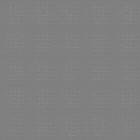

In [22]:
# set the path of the GIF file
anime_path = os.path.join(cur_image_dir, "%s-%s.%s" % (structure, dataset, 'gif'))
# create the GIF with imageio
with imageio.get_writer(anime_path, mode='I') as writer:
    filenames = glob.glob(os.path.join(cur_image_dir, '*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
# show the GIF in the notebook
display.Image(filename=anime_path)

### Tensor Board

In [23]:
%tensorboard --logdir=log_dir

Reusing TensorBoard on port 6006 (pid 12496), started 1:23:43 ago. (Use '!kill 12496' to kill it.)